# Урок 2. Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

#### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

## Выполнение

### 
Самостоятельно разобраться с тем, что такое tfidf. Документация: 
- https://scikitlearn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html 
- https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

### 
Модифицировать код функции `get_user_embedding` таким образом, чтобы считалось не среднее (как в примере `np.mean`), а медиана. 

Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: `roc auc`, `precision/recall/f_score` (для 3 последних - подобрать оптимальный порог с помощью `precision_recall_curve`, как это делалось на уроке)

In [1]:
import pandas as pd

#### Загрузим новости, пользователей пользователей и списки последних прочитанных новостей

In [33]:
news = pd.read_csv("Data/articles.csv")
users = pd.read_csv("Data/users_articles.csv")

In [50]:
display(news.head(3), users.head(3))

,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

#### Получаем векторные представления новостей

In [61]:
"Gensim — библиотека обработки естественного языка предназначения для «Тематического моделирования»."
# !pip install --upgrade gensim

"""
razdel - rule-based system for Russian sentence and word tokenization. See natasha.github.io article for more info.
https://github.com/natasha/razdel"""
# !pip install razdel

"Морфологический анализатор pymorphy2"
# !pip install pymorphy2

In [79]:
#предобработка текстов
from gensim.corpora.dictionary import Dictionary
import re
import numpy as np
from razdel import tokenize  # https://github.com/natasha/razdel
import pymorphy2

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carne\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [76]:
stopword_ru = nltk.corpus.stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [86]:
with open('Data/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [91]:
def clean_text(text):
    """
    Очистка текста
    :return: Очищеный текст
    """
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())

    # tokens = list(tokenize(text))
    # words = [_.text for _ in tokens]
    # words = [w for w in words if w not in stopword_ru]

    # return " ".join(words)
    return text


cache = {}


def lemmatization(text):
    """
    Лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова
    :return: Список отлемматизированых токенов
    """
    # [0]
    if not isinstance(text, str):
        text = str(text)

    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-':  # [2]
            w = w[1:]
        if len(w) > 1:  # [3]
            if w in cache:  # [4]
                words_lem.append(cache[w])
            else:  # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)

    words_lem_without_stopwords = [
        i for i in words_lem if not i in stopword_ru
    ]  # [6]

    return words_lem_without_stopwords

In [92]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-91-fd48c693ac78>:13: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 49 s


In [93]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 5min 54s


#### А теперь в 3 строчки обучим нашу модель

In [97]:
%%time
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Wall time: 23.1 s


Что такое common_dictionary и как он выглядит

In [107]:
print([common_dictionary[i] for i in range(10, 15)])

['ватутин', 'взаимодействие', 'власть', 'войти', 'вячеслав']


Все просто - это словарь наших слов

Запускаем обучение

In [109]:
%%time
from gensim.models import LdaModel

# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary, passes=10)

Wall time: 9min 17s


In [110]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [115]:
# Create a new corpus, made of previously unseen documents.
# Создайте новый корпус, состоящий из ранее невидимых документов.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]

print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.022381209),
 (2, 0.040111233),
 (8, 0.042935032),
 (9, 0.24575889),
 (10, 0.024110258),
 (11, 0.035184436),
 (14, 0.022522582),
 (22, 0.044421945),
 (24, 0.5086321)]

In [16]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: исследование женщина земля университет мужчина nn пациент
topic_1: грузия уточнять орудие сценарий страдать особенность аргумент
topic_2: исследование ребёнок снижение случай очень семья вопрос
topic_3: россия российский сша рынок миллиард американский система
topic_4: пенсия признать определение выдать вина депутат судья
topic_5: банк станция место восток солнце планета ступень
topic_6: миссия оборудование форум специальный пища пространство обращение
topic_7: фонд nn земля остров сотрудник китай завод
topic_8: nn фестиваль газ москва россия космос виза
topic_9: тур испания макаров сибирь определяться горожанин испанский
topic_10: украина гражданин украинский киев россия власть фронт
topic_11: взрыв кремль болезнь мальчик помещение небо дождь
topic_12: спрос дыра смерть погода климат прогноз боль
topic_13: проект москва россия программа технология российский объект
topic_14: россия население банка закон nn государство рак
topic_15: сша северный санкция американский эксперт до

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [17]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [18]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.0,0.000000,0.015594,0.000000,0.442676,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,4896,0.0,0.0,0.0,0.0,0.081482,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,4897,0.0,0.0,0.0,0.0,0.106190,0.000000,0.076351,0.000000,0.000000,...,0.000000,0.0,0.113634,0.038478,0.0,0.0,0.0,0.0,0.0,0.139882
3,4898,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.106727,0.072176,...,0.000000,0.0,0.579602,0.000000,0.0,0.0,0.0,0.0,0.0,0.026898
4,4899,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.041824,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [19]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [20]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [22]:
doc_dict[293622]

array([0.09863988, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.09360226, 0.        ,
       0.        , 0.06521784, 0.        , 0.02849769, 0.162049  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05593993, 0.28106534, 0.03323354, 0.        , 0.17070223])

In [79]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [81]:
get_user_embedding(user_articles_list)

array([0.01554548, 0.00600945, 0.07555787, 0.15870206, 0.        ,
       0.00239351, 0.        , 0.00358114, 0.0555495 , 0.        ,
       0.03336489, 0.        , 0.01460976, 0.04031443, 0.16594181,
       0.02318907, 0.00892161, 0.06157232, 0.00943773, 0.01622601,
       0.06671917, 0.0544566 , 0.09546342, 0.0748841 , 0.00240099])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [82]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [88]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость nn читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри nn позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать бара

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [95]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.061332,0.0,0.000000,0.138844,0.000000,0.022786,0.005009,0.009537,0.022137,...,0.004706,0.033443,0.015902,0.000000,0.009242,0.054624,0.071490,0.094061,0.019076,0.060116
1,u108690,0.019922,0.0,0.066779,0.109777,0.003853,0.008922,0.005362,0.054272,0.031694,...,0.027435,0.020045,0.108680,0.000000,0.031309,0.072432,0.072964,0.027452,0.023798,0.008979
2,u108339,0.038603,0.0,0.035268,0.126407,0.002727,0.012388,0.000000,0.056895,0.036814,...,0.014383,0.004212,0.037258,0.006449,0.028209,0.112988,0.001675,0.063337,0.066539,0.004105


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [96]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [99]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.061332,0.0,0.000000,0.138844,0.000000,0.022786,0.005009,0.009537,0.022137,...,0.033443,0.015902,0.000000,0.009242,0.054624,0.071490,0.094061,0.019076,0.060116,0
1,u108690,0.019922,0.0,0.066779,0.109777,0.003853,0.008922,0.005362,0.054272,0.031694,...,0.020045,0.108680,0.000000,0.031309,0.072432,0.072964,0.027452,0.023798,0.008979,1
2,u108339,0.038603,0.0,0.035268,0.126407,0.002727,0.012388,0.000000,0.056895,0.036814,...,0.004212,0.037258,0.006449,0.028209,0.112988,0.001675,0.063337,0.066539,0.004105,1


In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [101]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [103]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [104]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.26928055, 0.01637495, 0.38132058, 0.21628033, 0.06282484,
       0.07724038, 0.12697998, 0.01268557, 0.02635503, 0.07920181])

In [105]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [106]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.253757, F-Score=0.696, Precision=0.651, Recall=0.747


In [109]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1657   98]
 [  63  182]]


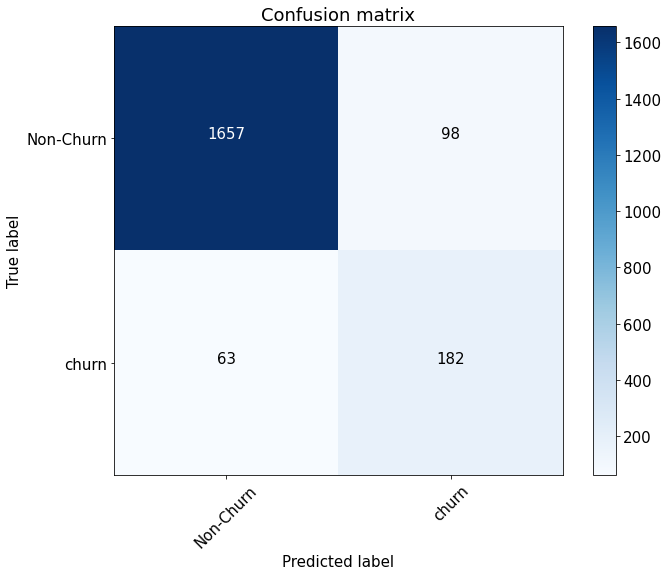

In [112]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [113]:
roc_auc_score(y_test, preds)

0.9507924879353452

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### 
Повторить п.2, но используя уже не медиану, а max

### 
(опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

### 
Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: `mean`, `median`, `max`, `idf_mean` по метрикам `roc_auc`, `precision`, `recall`, `f_score`

### 
Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

### Домашнее задание